In [1]:
import os
from os.path import join
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import gc
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")


# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# Config

In [2]:
# Load
X_train = torch.load('Data/X_train_new.pt')
X_val = torch.load('Data/X_val_new.pt')
X_test = torch.load('Data/X_test_new.pt')
y_train = torch.load('Data/y_train_new.pt')
y_val = torch.load('Data/y_val_new.pt')
y_test = torch.load('Data/y_test_new.pt')

In [3]:
BATCH_SIZE_TRAIN = 256  # 32 -> 256
BATCH_SIZE_VAL = 512
BATCH_SIZE_TEST = 512

RE_SIZE = 96
INPUT_CH = 1    # Must be 1
NUM_CLASSES = 9
IS_PRETRAINED = False
LEARNING_RATE = 1e-4
EPOCHS = 80

save_name = f'resnet34_batch{BATCH_SIZE_TRAIN}_aug_focalv2'
save_path = f'models/{save_name}.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(save_name, save_path)

resnet34_batch256_aug_focalv2 models/resnet34_batch256_aug_focalv2.pt


# Dataset

In [4]:
from albumentations.pytorch.transforms import ToTensorV2
from utils import get_transforms, display_aug
# Transforms and Dataset

class WaferDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        # X = self.df.waferMap.values[idx]
        # y = self.df.failureNum.values[idx].int()

        if self.transform:
            X = self.transform(image=X)
            
        return {
            'img' : X['image'], 
            'label': y
        }

train_transform, else_transform = get_transforms(size=RE_SIZE)

train_dataset = WaferDataset(X_train, y_train, transform=train_transform)
val_dataset = WaferDataset(X_val, y_val, transform=else_transform)
test_dataset = WaferDataset(X_test, y_test, transform=else_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))

24863 5328 5328


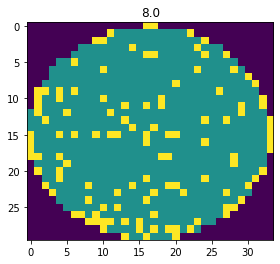

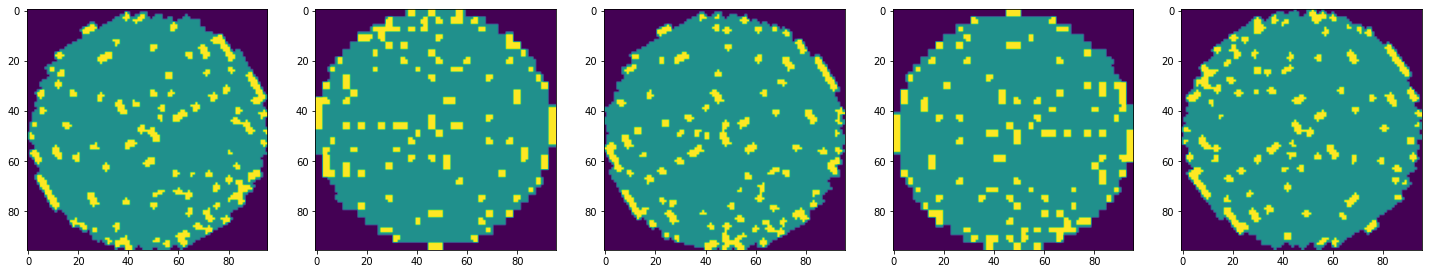

In [5]:
display_aug(imgs=X_train, transform=train_transform, labels = y_train)

# Model

In [6]:
from torchvision.models import resnet34
from torchinfo import summary

model = resnet34(pretrained=IS_PRETRAINED)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)
# summary(model, (BATCH_SIZE_TRAIN, INPUT_CH, RE_SIZE, RE_SIZE), device='cpu')

In [7]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights,dtype=torch.float)

In [8]:
np.unique(y_train)

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [9]:
np.unique(y_train, return_counts=True)[1]

array([3006,  389, 3632, 6776, 2515,  606,  835,  104, 7000], dtype=int64)

In [10]:
sqrt_weights = torch.sqrt(weights)
print(weights)
print(sqrt_weights)

tensor([ 0.9190,  7.1017,  0.7606,  0.4077,  1.0984,  4.5587,  3.3084, 26.5630,
         0.3947])
tensor([0.9587, 2.6649, 0.8721, 0.6385, 1.0481, 2.1351, 1.8189, 5.1539, 0.6282])


In [11]:
np.unique(y_train, return_counts=True)[1] * np.array(weights)

array([2762.5554775 , 2762.55548334, 2762.55559635, 2762.55562663,
       2762.55544186, 2762.55549145, 2762.55553722, 2762.55554199,
       2762.55550981])

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils import FocalLoss

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = FocalLoss(weights=sqrt_weights.cuda(), gamma=2, reduce=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.1, patience=5, cooldown=3, threshold_mode='rel', verbose=True)

In [13]:
from sklearn.metrics import f1_score 

def train(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    scaler = torch.cuda.amp.GradScaler()
    tqdm_loader = tqdm(enumerate(loader))
    model.train()
    for batch_idx, batch in tqdm_loader:
        img = batch['img'].float().cuda()
        label = batch['label'].long().cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # mixed precision + gradient clipping
        with torch.cuda.amp.autocast():
            output = model(img).cuda()
            loss = criterion(output, label)

        scaler.scale(loss).backward() 
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        scaler.step(optimizer)
        scaler.update()
        
        # # forward + backward + optimize
        # output = model(img)
        # loss = criterion(output, label)
        # loss.backward()
        # optimizer.step()
        
        # stats
        preds = torch.argmax(output, dim=1)
        correct = torch.eq(preds, label).sum()
        running_loss += loss.item() 
        running_corrects += correct
        running_num += len(label)
        
        for item in label.cpu().numpy():
            y_true.append(item)
        for item in preds.cpu().numpy():
            y_pred.append(item)
        
        tqdm_loader.set_postfix({
            'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
            'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
            'Batch Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
            'Batch ACC': '{:06f}'.format(correct / len(label)),
            'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_corrects / running_num
    epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
    epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
    writer.add_scalar('F1_macro/Train', epoch_f1_macro, epoch)
    writer.add_scalar('F1_weighted/Train', epoch_f1_weighted, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f} lr: {optimizer.param_groups[0]["lr"]:.6f}')
    
def evaluate(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            img = batch['img'].float().cuda()   
            label = batch['label'].long().cuda()
            output = model(img).cuda()
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects += correct
            running_num += len(label)

            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

            # tqdm_loader.set_postfix({
            #     'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
            #     'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
            #     'Batch Loss': '{:06f}'.format(loss.item()),
            #     'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
            #     'Batch ACC': '{:06f}'.format(correct / len(label)),
            #     'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
            # })

        epoch_loss = running_loss / len(loader)
        epoch_acc = running_corrects / running_num
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        scheduler.step(epoch_loss)
        
        writer.add_scalar('Loss/Valid', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', epoch_acc, epoch)
        writer.add_scalar('F1_macro/Valid', epoch_f1_macro, epoch)
        writer.add_scalar('F1_weighted/Valid', epoch_f1_weighted, epoch)
        
        print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        print(f'{running_corrects}/{running_num} correct')
        
        epoch_acc = epoch_acc.detach().cpu().numpy()    # tensor->numpy
        val_acc_list.append(epoch_acc)
        val_f1_macro_list.append(epoch_f1_macro)
        val_f1_weighted_list.append(epoch_f1_weighted)
        
        if np.max(val_f1_macro_list) == val_f1_macro_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            torch.save(model.state_dict(), save_path)   # weighted F1 기준


# Train

In [14]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)

val_acc_list = []
val_f1_macro_list = []
val_f1_weighted_list = []

model = model.cuda()

for epoch in range(EPOCHS):
    train(model, train_loader, epoch, EPOCHS)
    evaluate(model, val_loader, epoch, EPOCHS)

98it [00:10,  9.26it/s, Epoch=1/80, Batch=98/98, Batch Loss=0.224682, Mean Loss=0.559543, Batch ACC=0.741935, Mean ACC=0.647187]


Train loss: 0.559543, Train ACC: 0.647187, F1_macro: 0.568026, F1_weighted: 0.656125 lr: 0.000100
Valid loss: 0.304284, Valid ACC: 0.772147, F1_macro: 0.729456, F1_weighted: 0.778646
4114/5328 correct


98it [00:07, 12.85it/s, Epoch=2/80, Batch=98/98, Batch Loss=0.151855, Mean Loss=0.264795, Batch ACC=0.870968, Mean ACC=0.800909]


Train loss: 0.264795, Train ACC: 0.800909, F1_macro: 0.735072, F1_weighted: 0.808284 lr: 0.000100
Valid loss: 0.279710, Valid ACC: 0.793731, F1_macro: 0.738486, F1_weighted: 0.798101
4229/5328 correct


98it [00:07, 12.82it/s, Epoch=3/80, Batch=98/98, Batch Loss=0.246388, Mean Loss=0.206586, Batch ACC=0.709677, Mean ACC=0.837389]


Train loss: 0.206586, Train ACC: 0.837389, F1_macro: 0.780687, F1_weighted: 0.846209 lr: 0.000100
Valid loss: 0.193012, Valid ACC: 0.855480, F1_macro: 0.785475, F1_weighted: 0.860349
4558/5328 correct


98it [00:07, 12.94it/s, Epoch=4/80, Batch=98/98, Batch Loss=0.175108, Mean Loss=0.177398, Batch ACC=0.870968, Mean ACC=0.855770]


Train loss: 0.177398, Train ACC: 0.855770, F1_macro: 0.802882, F1_weighted: 0.864514 lr: 0.000100
Valid loss: 0.166163, Valid ACC: 0.878754, F1_macro: 0.832053, F1_weighted: 0.881965
4682/5328 correct


98it [00:07, 12.72it/s, Epoch=5/80, Batch=98/98, Batch Loss=0.155041, Mean Loss=0.159103, Batch ACC=0.870968, Mean ACC=0.871053]


Train loss: 0.159103, Train ACC: 0.871053, F1_macro: 0.810684, F1_weighted: 0.877943 lr: 0.000100
Valid loss: 0.152819, Valid ACC: 0.887575, F1_macro: 0.836308, F1_weighted: 0.890976
4729/5328 correct


98it [00:07, 12.78it/s, Epoch=6/80, Batch=98/98, Batch Loss=0.158721, Mean Loss=0.142421, Batch ACC=0.870968, Mean ACC=0.880224]


Train loss: 0.142421, Train ACC: 0.880224, F1_macro: 0.829824, F1_weighted: 0.886076 lr: 0.000100
Valid loss: 0.189752, Valid ACC: 0.878191, F1_macro: 0.800485, F1_weighted: 0.881007
4679/5328 correct


98it [00:07, 12.65it/s, Epoch=7/80, Batch=98/98, Batch Loss=0.382092, Mean Loss=0.135278, Batch ACC=0.903226, Mean ACC=0.890118]


Train loss: 0.135278, Train ACC: 0.890118, F1_macro: 0.847817, F1_weighted: 0.895018 lr: 0.000100
Valid loss: 0.136283, Valid ACC: 0.892080, F1_macro: 0.851477, F1_weighted: 0.895637
4753/5328 correct


98it [00:07, 13.14it/s, Epoch=8/80, Batch=98/98, Batch Loss=0.110182, Mean Loss=0.129381, Batch ACC=0.935484, Mean ACC=0.891606]


Train loss: 0.129381, Train ACC: 0.891606, F1_macro: 0.841475, F1_weighted: 0.896156 lr: 0.000100
Valid loss: 0.121652, Valid ACC: 0.895646, F1_macro: 0.847668, F1_weighted: 0.898525
4772/5328 correct


98it [00:07, 13.15it/s, Epoch=9/80, Batch=98/98, Batch Loss=0.242564, Mean Loss=0.116586, Batch ACC=0.870968, Mean ACC=0.895186]


Train loss: 0.116586, Train ACC: 0.895186, F1_macro: 0.855161, F1_weighted: 0.899688 lr: 0.000100
Valid loss: 0.132013, Valid ACC: 0.906156, F1_macro: 0.854935, F1_weighted: 0.907022
4828/5328 correct


98it [00:07, 13.25it/s, Epoch=10/80, Batch=98/98, Batch Loss=0.031292, Mean Loss=0.106236, Batch ACC=0.967742, Mean ACC=0.903149]


Train loss: 0.106236, Train ACC: 0.903149, F1_macro: 0.864757, F1_weighted: 0.906732 lr: 0.000100
Valid loss: 0.148078, Valid ACC: 0.910848, F1_macro: 0.854155, F1_weighted: 0.909038
4853/5328 correct


98it [00:07, 13.22it/s, Epoch=11/80, Batch=98/98, Batch Loss=0.063601, Mean Loss=0.105106, Batch ACC=0.870968, Mean ACC=0.904879]


Train loss: 0.105106, Train ACC: 0.904879, F1_macro: 0.866520, F1_weighted: 0.908072 lr: 0.000100
Valid loss: 0.138786, Valid ACC: 0.883258, F1_macro: 0.817693, F1_weighted: 0.889694
4706/5328 correct


98it [00:07, 13.28it/s, Epoch=12/80, Batch=98/98, Batch Loss=0.243546, Mean Loss=0.102666, Batch ACC=0.838710, Mean ACC=0.909182]


Train loss: 0.102666, Train ACC: 0.909182, F1_macro: 0.868172, F1_weighted: 0.911888 lr: 0.000100
Valid loss: 0.121518, Valid ACC: 0.907845, F1_macro: 0.851655, F1_weighted: 0.908809
4837/5328 correct


98it [00:07, 12.98it/s, Epoch=13/80, Batch=98/98, Batch Loss=0.016408, Mean Loss=0.098317, Batch ACC=1.000000, Mean ACC=0.915095]


Train loss: 0.098317, Train ACC: 0.915095, F1_macro: 0.869191, F1_weighted: 0.917518 lr: 0.000100
Valid loss: 0.148718, Valid ACC: 0.910473, F1_macro: 0.829309, F1_weighted: 0.911730
4851/5328 correct


98it [00:07, 13.13it/s, Epoch=14/80, Batch=98/98, Batch Loss=0.140960, Mean Loss=0.095412, Batch ACC=0.967742, Mean ACC=0.913124]


Train loss: 0.095412, Train ACC: 0.913124, F1_macro: 0.876634, F1_weighted: 0.915380 lr: 0.000100
Epoch    14: reducing learning rate of group 0 to 5.0000e-05.
Valid loss: 0.141580, Valid ACC: 0.881381, F1_macro: 0.827830, F1_weighted: 0.885629
4696/5328 correct


98it [00:07, 12.84it/s, Epoch=15/80, Batch=98/98, Batch Loss=0.140205, Mean Loss=0.079737, Batch ACC=0.935484, Mean ACC=0.923823]


Train loss: 0.079737, Train ACC: 0.923823, F1_macro: 0.895422, F1_weighted: 0.925512 lr: 0.000050
Valid loss: 0.093720, Valid ACC: 0.918731, F1_macro: 0.874570, F1_weighted: 0.920975
4895/5328 correct


98it [00:07, 13.05it/s, Epoch=16/80, Batch=98/98, Batch Loss=0.072858, Mean Loss=0.073194, Batch ACC=0.903226, Mean ACC=0.928770]


Train loss: 0.073194, Train ACC: 0.928770, F1_macro: 0.904782, F1_weighted: 0.930232 lr: 0.000050
Valid loss: 0.084029, Valid ACC: 0.927740, F1_macro: 0.896901, F1_weighted: 0.928725
4943/5328 correct


98it [00:07, 13.14it/s, Epoch=17/80, Batch=98/98, Batch Loss=0.038847, Mean Loss=0.073692, Batch ACC=0.967742, Mean ACC=0.929655]


Train loss: 0.073692, Train ACC: 0.929655, F1_macro: 0.900788, F1_weighted: 0.930933 lr: 0.000050
Valid loss: 0.091105, Valid ACC: 0.927740, F1_macro: 0.895551, F1_weighted: 0.929154
4943/5328 correct


98it [00:07, 12.94it/s, Epoch=18/80, Batch=98/98, Batch Loss=0.038962, Mean Loss=0.066854, Batch ACC=0.935484, Mean ACC=0.932711]


Train loss: 0.066854, Train ACC: 0.932711, F1_macro: 0.913486, F1_weighted: 0.934003 lr: 0.000050
Valid loss: 0.084580, Valid ACC: 0.927740, F1_macro: 0.900211, F1_weighted: 0.928546
4943/5328 correct


98it [00:07, 12.84it/s, Epoch=19/80, Batch=98/98, Batch Loss=0.081116, Mean Loss=0.069423, Batch ACC=0.903226, Mean ACC=0.933315]


Train loss: 0.069423, Train ACC: 0.933315, F1_macro: 0.910243, F1_weighted: 0.934586 lr: 0.000050
Valid loss: 0.089390, Valid ACC: 0.925676, F1_macro: 0.893833, F1_weighted: 0.926315
4932/5328 correct


98it [00:07, 12.97it/s, Epoch=20/80, Batch=98/98, Batch Loss=0.042864, Mean Loss=0.062217, Batch ACC=0.903226, Mean ACC=0.935486]


Train loss: 0.062217, Train ACC: 0.935486, F1_macro: 0.914589, F1_weighted: 0.936476 lr: 0.000050
Valid loss: 0.090197, Valid ACC: 0.923236, F1_macro: 0.886226, F1_weighted: 0.925357
4919/5328 correct


98it [00:07, 12.95it/s, Epoch=21/80, Batch=98/98, Batch Loss=0.140944, Mean Loss=0.064503, Batch ACC=0.838710, Mean ACC=0.937980]


Train loss: 0.064503, Train ACC: 0.937980, F1_macro: 0.918104, F1_weighted: 0.938976 lr: 0.000050
Valid loss: 0.102506, Valid ACC: 0.925863, F1_macro: 0.878986, F1_weighted: 0.926294
4933/5328 correct


98it [00:07, 12.86it/s, Epoch=22/80, Batch=98/98, Batch Loss=0.103035, Mean Loss=0.061707, Batch ACC=0.870968, Mean ACC=0.936452]


Train loss: 0.061707, Train ACC: 0.936452, F1_macro: 0.916515, F1_weighted: 0.937560 lr: 0.000050
Valid loss: 0.092428, Valid ACC: 0.928303, F1_macro: 0.896328, F1_weighted: 0.929491
4946/5328 correct


98it [00:07, 12.88it/s, Epoch=23/80, Batch=98/98, Batch Loss=0.044555, Mean Loss=0.057808, Batch ACC=0.935484, Mean ACC=0.940836]


Train loss: 0.057808, Train ACC: 0.940836, F1_macro: 0.922096, F1_weighted: 0.941746 lr: 0.000050
Epoch    23: reducing learning rate of group 0 to 2.5000e-05.
Valid loss: 0.085499, Valid ACC: 0.930743, F1_macro: 0.907727, F1_weighted: 0.931595
4959/5328 correct


98it [00:07, 12.89it/s, Epoch=24/80, Batch=98/98, Batch Loss=0.026791, Mean Loss=0.055543, Batch ACC=0.935484, Mean ACC=0.943008]


Train loss: 0.055543, Train ACC: 0.943008, F1_macro: 0.924854, F1_weighted: 0.943764 lr: 0.000025
Valid loss: 0.079039, Valid ACC: 0.933371, F1_macro: 0.906268, F1_weighted: 0.933862
4973/5328 correct


98it [00:07, 12.99it/s, Epoch=25/80, Batch=98/98, Batch Loss=0.088511, Mean Loss=0.054129, Batch ACC=0.967742, Mean ACC=0.944576]


Train loss: 0.054129, Train ACC: 0.944576, F1_macro: 0.927914, F1_weighted: 0.945288 lr: 0.000025
Valid loss: 0.076144, Valid ACC: 0.932995, F1_macro: 0.910079, F1_weighted: 0.934005
4971/5328 correct


98it [00:07, 12.98it/s, Epoch=26/80, Batch=98/98, Batch Loss=0.019635, Mean Loss=0.051527, Batch ACC=0.967742, Mean ACC=0.947311]


Train loss: 0.051527, Train ACC: 0.947311, F1_macro: 0.930454, F1_weighted: 0.948116 lr: 0.000025
Valid loss: 0.080416, Valid ACC: 0.929805, F1_macro: 0.898469, F1_weighted: 0.930882
4954/5328 correct


98it [00:07, 12.95it/s, Epoch=27/80, Batch=98/98, Batch Loss=0.204801, Mean Loss=0.054472, Batch ACC=0.903226, Mean ACC=0.945139]


Train loss: 0.054472, Train ACC: 0.945139, F1_macro: 0.927657, F1_weighted: 0.945883 lr: 0.000025
Valid loss: 0.075544, Valid ACC: 0.930556, F1_macro: 0.903404, F1_weighted: 0.931635
4958/5328 correct


98it [00:07, 12.95it/s, Epoch=28/80, Batch=98/98, Batch Loss=0.040932, Mean Loss=0.051127, Batch ACC=0.967742, Mean ACC=0.946145]


Train loss: 0.051127, Train ACC: 0.946145, F1_macro: 0.930358, F1_weighted: 0.946871 lr: 0.000025
Valid loss: 0.075068, Valid ACC: 0.934122, F1_macro: 0.908916, F1_weighted: 0.935216
4977/5328 correct


98it [00:07, 12.82it/s, Epoch=29/80, Batch=98/98, Batch Loss=0.043860, Mean Loss=0.049736, Batch ACC=0.903226, Mean ACC=0.947070]


Train loss: 0.049736, Train ACC: 0.947070, F1_macro: 0.930947, F1_weighted: 0.947797 lr: 0.000025
Valid loss: 0.077231, Valid ACC: 0.933371, F1_macro: 0.910220, F1_weighted: 0.934230
4973/5328 correct


98it [00:07, 12.84it/s, Epoch=30/80, Batch=98/98, Batch Loss=0.059711, Mean Loss=0.047846, Batch ACC=0.935484, Mean ACC=0.948598]


Train loss: 0.047846, Train ACC: 0.948598, F1_macro: 0.935064, F1_weighted: 0.949160 lr: 0.000025
Valid loss: 0.074233, Valid ACC: 0.932245, F1_macro: 0.903613, F1_weighted: 0.933270
4967/5328 correct


98it [00:07, 12.91it/s, Epoch=31/80, Batch=98/98, Batch Loss=0.010073, Mean Loss=0.045263, Batch ACC=1.000000, Mean ACC=0.951293]


Train loss: 0.045263, Train ACC: 0.951293, F1_macro: 0.939344, F1_weighted: 0.951910 lr: 0.000025
Valid loss: 0.078784, Valid ACC: 0.940878, F1_macro: 0.918395, F1_weighted: 0.941039
5013/5328 correct


98it [00:07, 13.21it/s, Epoch=32/80, Batch=98/98, Batch Loss=0.267715, Mean Loss=0.049313, Batch ACC=0.870968, Mean ACC=0.950408]


Train loss: 0.049313, Train ACC: 0.950408, F1_macro: 0.937694, F1_weighted: 0.951048 lr: 0.000025
Valid loss: 0.080580, Valid ACC: 0.938251, F1_macro: 0.911364, F1_weighted: 0.938725
4999/5328 correct


98it [00:07, 12.99it/s, Epoch=33/80, Batch=98/98, Batch Loss=0.028440, Mean Loss=0.046288, Batch ACC=0.967742, Mean ACC=0.950087]


Train loss: 0.046288, Train ACC: 0.950087, F1_macro: 0.935512, F1_weighted: 0.950614 lr: 0.000025
Epoch    33: reducing learning rate of group 0 to 1.2500e-05.
Valid loss: 0.081196, Valid ACC: 0.936937, F1_macro: 0.914524, F1_weighted: 0.937651
4992/5328 correct


98it [00:07, 12.34it/s, Epoch=34/80, Batch=98/98, Batch Loss=0.016844, Mean Loss=0.042952, Batch ACC=0.935484, Mean ACC=0.954189]


Train loss: 0.042952, Train ACC: 0.954189, F1_macro: 0.943032, F1_weighted: 0.954608 lr: 0.000013
Valid loss: 0.076217, Valid ACC: 0.939189, F1_macro: 0.916166, F1_weighted: 0.939778
5004/5328 correct


98it [00:07, 12.65it/s, Epoch=35/80, Batch=98/98, Batch Loss=0.014100, Mean Loss=0.044807, Batch ACC=0.903226, Mean ACC=0.952460]


Train loss: 0.044807, Train ACC: 0.952460, F1_macro: 0.940110, F1_weighted: 0.952940 lr: 0.000013
Valid loss: 0.077071, Valid ACC: 0.937688, F1_macro: 0.909979, F1_weighted: 0.938321
4996/5328 correct


98it [00:07, 12.62it/s, Epoch=36/80, Batch=98/98, Batch Loss=0.032632, Mean Loss=0.041748, Batch ACC=0.967742, Mean ACC=0.955918]


Train loss: 0.041748, Train ACC: 0.955918, F1_macro: 0.944069, F1_weighted: 0.956293 lr: 0.000013
Valid loss: 0.073316, Valid ACC: 0.936374, F1_macro: 0.910896, F1_weighted: 0.937155
4989/5328 correct


98it [00:07, 12.88it/s, Epoch=37/80, Batch=98/98, Batch Loss=0.001970, Mean Loss=0.041091, Batch ACC=1.000000, Mean ACC=0.954350]


Train loss: 0.041091, Train ACC: 0.954350, F1_macro: 0.943365, F1_weighted: 0.954773 lr: 0.000013
Valid loss: 0.076338, Valid ACC: 0.936749, F1_macro: 0.913570, F1_weighted: 0.937497
4991/5328 correct


98it [00:07, 12.98it/s, Epoch=38/80, Batch=98/98, Batch Loss=0.010777, Mean Loss=0.041841, Batch ACC=0.935484, Mean ACC=0.955436]


Train loss: 0.041841, Train ACC: 0.955436, F1_macro: 0.942256, F1_weighted: 0.955831 lr: 0.000013
Valid loss: 0.076669, Valid ACC: 0.939377, F1_macro: 0.914972, F1_weighted: 0.940112
5005/5328 correct


98it [00:07, 13.00it/s, Epoch=39/80, Batch=98/98, Batch Loss=0.014906, Mean Loss=0.040526, Batch ACC=1.000000, Mean ACC=0.956763]


Train loss: 0.040526, Train ACC: 0.956763, F1_macro: 0.945938, F1_weighted: 0.957239 lr: 0.000013
Valid loss: 0.075578, Valid ACC: 0.940128, F1_macro: 0.916308, F1_weighted: 0.940501
5009/5328 correct


98it [00:07, 12.61it/s, Epoch=40/80, Batch=98/98, Batch Loss=0.083482, Mean Loss=0.041095, Batch ACC=0.935484, Mean ACC=0.954792]


Train loss: 0.041095, Train ACC: 0.954792, F1_macro: 0.945577, F1_weighted: 0.955239 lr: 0.000013
Valid loss: 0.078781, Valid ACC: 0.940503, F1_macro: 0.915403, F1_weighted: 0.941030
5011/5328 correct


98it [00:07, 12.67it/s, Epoch=41/80, Batch=98/98, Batch Loss=0.082160, Mean Loss=0.040175, Batch ACC=0.967742, Mean ACC=0.956844]


Train loss: 0.040175, Train ACC: 0.956844, F1_macro: 0.947036, F1_weighted: 0.957242 lr: 0.000013
Valid loss: 0.078014, Valid ACC: 0.939002, F1_macro: 0.914815, F1_weighted: 0.939449
5003/5328 correct


98it [00:07, 12.72it/s, Epoch=42/80, Batch=98/98, Batch Loss=0.220741, Mean Loss=0.042087, Batch ACC=0.903226, Mean ACC=0.956200]


Train loss: 0.042087, Train ACC: 0.956200, F1_macro: 0.943926, F1_weighted: 0.956617 lr: 0.000013
Epoch    42: reducing learning rate of group 0 to 6.2500e-06.
Valid loss: 0.076096, Valid ACC: 0.936374, F1_macro: 0.908193, F1_weighted: 0.936952
4989/5328 correct


98it [00:07, 12.84it/s, Epoch=43/80, Batch=98/98, Batch Loss=0.026636, Mean Loss=0.039168, Batch ACC=0.967742, Mean ACC=0.958332]


Train loss: 0.039168, Train ACC: 0.958332, F1_macro: 0.946551, F1_weighted: 0.958770 lr: 0.000006
Valid loss: 0.076168, Valid ACC: 0.941254, F1_macro: 0.916078, F1_weighted: 0.941796
5015/5328 correct


98it [00:07, 12.91it/s, Epoch=44/80, Batch=98/98, Batch Loss=0.017937, Mean Loss=0.040610, Batch ACC=0.967742, Mean ACC=0.956039]


Train loss: 0.040610, Train ACC: 0.956039, F1_macro: 0.944050, F1_weighted: 0.956566 lr: 0.000006
Valid loss: 0.075400, Valid ACC: 0.940128, F1_macro: 0.913983, F1_weighted: 0.940534
5009/5328 correct


98it [00:07, 12.67it/s, Epoch=45/80, Batch=98/98, Batch Loss=0.006478, Mean Loss=0.039433, Batch ACC=1.000000, Mean ACC=0.958613]


Train loss: 0.039433, Train ACC: 0.958613, F1_macro: 0.948191, F1_weighted: 0.959016 lr: 0.000006
Valid loss: 0.077943, Valid ACC: 0.942005, F1_macro: 0.917833, F1_weighted: 0.942309
5019/5328 correct


98it [00:07, 13.12it/s, Epoch=46/80, Batch=98/98, Batch Loss=0.022792, Mean Loss=0.038022, Batch ACC=0.967742, Mean ACC=0.959579]


Train loss: 0.038022, Train ACC: 0.959579, F1_macro: 0.948511, F1_weighted: 0.959898 lr: 0.000006
Valid loss: 0.077182, Valid ACC: 0.941629, F1_macro: 0.918612, F1_weighted: 0.941796
5017/5328 correct


98it [00:07, 12.81it/s, Epoch=47/80, Batch=98/98, Batch Loss=0.012243, Mean Loss=0.037754, Batch ACC=0.967742, Mean ACC=0.958975]


Train loss: 0.037754, Train ACC: 0.958975, F1_macro: 0.949801, F1_weighted: 0.959314 lr: 0.000006
Valid loss: 0.073829, Valid ACC: 0.939752, F1_macro: 0.916631, F1_weighted: 0.940264
5007/5328 correct


98it [00:07, 12.56it/s, Epoch=48/80, Batch=98/98, Batch Loss=0.064973, Mean Loss=0.036420, Batch ACC=0.870968, Mean ACC=0.959257]


Train loss: 0.036420, Train ACC: 0.959257, F1_macro: 0.952693, F1_weighted: 0.959581 lr: 0.000006
Valid loss: 0.076313, Valid ACC: 0.942005, F1_macro: 0.919774, F1_weighted: 0.942292
5019/5328 correct


98it [00:07, 12.42it/s, Epoch=49/80, Batch=98/98, Batch Loss=0.049683, Mean Loss=0.038920, Batch ACC=0.903226, Mean ACC=0.959096]


Train loss: 0.038920, Train ACC: 0.959096, F1_macro: 0.948452, F1_weighted: 0.959417 lr: 0.000006
Valid loss: 0.075865, Valid ACC: 0.942568, F1_macro: 0.920441, F1_weighted: 0.942928
5022/5328 correct


98it [00:07, 12.68it/s, Epoch=50/80, Batch=98/98, Batch Loss=0.037381, Mean Loss=0.039523, Batch ACC=0.903226, Mean ACC=0.958452]


Train loss: 0.039523, Train ACC: 0.958452, F1_macro: 0.948727, F1_weighted: 0.958856 lr: 0.000006
Valid loss: 0.075174, Valid ACC: 0.943131, F1_macro: 0.917862, F1_weighted: 0.943637
5025/5328 correct


98it [00:07, 12.75it/s, Epoch=51/80, Batch=98/98, Batch Loss=0.055311, Mean Loss=0.039290, Batch ACC=0.903226, Mean ACC=0.958211]


Train loss: 0.039290, Train ACC: 0.958211, F1_macro: 0.947558, F1_weighted: 0.958590 lr: 0.000006
Epoch    51: reducing learning rate of group 0 to 3.1250e-06.
Valid loss: 0.074604, Valid ACC: 0.942380, F1_macro: 0.917968, F1_weighted: 0.942765
5021/5328 correct


98it [00:07, 12.77it/s, Epoch=52/80, Batch=98/98, Batch Loss=0.023178, Mean Loss=0.036165, Batch ACC=0.967742, Mean ACC=0.960785]


Train loss: 0.036165, Train ACC: 0.960785, F1_macro: 0.951843, F1_weighted: 0.961202 lr: 0.000003
Valid loss: 0.075650, Valid ACC: 0.943318, F1_macro: 0.917267, F1_weighted: 0.943617
5026/5328 correct


98it [00:07, 12.79it/s, Epoch=53/80, Batch=98/98, Batch Loss=0.008926, Mean Loss=0.035954, Batch ACC=1.000000, Mean ACC=0.959498]


Train loss: 0.035954, Train ACC: 0.959498, F1_macro: 0.949021, F1_weighted: 0.959896 lr: 0.000003
Valid loss: 0.073983, Valid ACC: 0.941441, F1_macro: 0.915672, F1_weighted: 0.941761
5016/5328 correct


98it [00:07, 13.04it/s, Epoch=54/80, Batch=98/98, Batch Loss=0.014861, Mean Loss=0.038302, Batch ACC=1.000000, Mean ACC=0.957849]


Train loss: 0.038302, Train ACC: 0.957849, F1_macro: 0.948471, F1_weighted: 0.958278 lr: 0.000003
Valid loss: 0.073549, Valid ACC: 0.942380, F1_macro: 0.918899, F1_weighted: 0.942729
5021/5328 correct


98it [00:07, 12.91it/s, Epoch=55/80, Batch=98/98, Batch Loss=0.028525, Mean Loss=0.039299, Batch ACC=1.000000, Mean ACC=0.960584]


Train loss: 0.039299, Train ACC: 0.960584, F1_macro: 0.949742, F1_weighted: 0.960933 lr: 0.000003
Valid loss: 0.074753, Valid ACC: 0.941441, F1_macro: 0.915469, F1_weighted: 0.941819
5016/5328 correct


98it [00:07, 12.71it/s, Epoch=56/80, Batch=98/98, Batch Loss=0.016043, Mean Loss=0.036572, Batch ACC=0.967742, Mean ACC=0.961067]


Train loss: 0.036572, Train ACC: 0.961067, F1_macro: 0.952050, F1_weighted: 0.961474 lr: 0.000003
Valid loss: 0.075448, Valid ACC: 0.942943, F1_macro: 0.918950, F1_weighted: 0.943210
5024/5328 correct


98it [00:07, 12.59it/s, Epoch=57/80, Batch=98/98, Batch Loss=0.061241, Mean Loss=0.035979, Batch ACC=0.935484, Mean ACC=0.960584]


Train loss: 0.035979, Train ACC: 0.960584, F1_macro: 0.950325, F1_weighted: 0.960945 lr: 0.000003
Valid loss: 0.075083, Valid ACC: 0.942755, F1_macro: 0.921202, F1_weighted: 0.943137
5023/5328 correct


98it [00:07, 12.81it/s, Epoch=58/80, Batch=98/98, Batch Loss=0.003273, Mean Loss=0.036356, Batch ACC=1.000000, Mean ACC=0.959739]


Train loss: 0.036356, Train ACC: 0.959739, F1_macro: 0.949876, F1_weighted: 0.960075 lr: 0.000003
Valid loss: 0.073994, Valid ACC: 0.943694, F1_macro: 0.921579, F1_weighted: 0.943973
5028/5328 correct


98it [00:07, 12.70it/s, Epoch=59/80, Batch=98/98, Batch Loss=0.275565, Mean Loss=0.037924, Batch ACC=0.903226, Mean ACC=0.960705]


Train loss: 0.037924, Train ACC: 0.960705, F1_macro: 0.950696, F1_weighted: 0.960988 lr: 0.000003
Valid loss: 0.074648, Valid ACC: 0.943318, F1_macro: 0.920878, F1_weighted: 0.943562
5026/5328 correct


98it [00:07, 12.77it/s, Epoch=60/80, Batch=98/98, Batch Loss=0.194721, Mean Loss=0.038557, Batch ACC=0.967742, Mean ACC=0.961067]


Train loss: 0.038557, Train ACC: 0.961067, F1_macro: 0.950721, F1_weighted: 0.961399 lr: 0.000003
Epoch    60: reducing learning rate of group 0 to 1.5625e-06.
Valid loss: 0.074199, Valid ACC: 0.942192, F1_macro: 0.919655, F1_weighted: 0.942436
5020/5328 correct


98it [00:07, 12.60it/s, Epoch=61/80, Batch=98/98, Batch Loss=0.003482, Mean Loss=0.035571, Batch ACC=1.000000, Mean ACC=0.961067]


Train loss: 0.035571, Train ACC: 0.961067, F1_macro: 0.953565, F1_weighted: 0.961425 lr: 0.000002
Valid loss: 0.074459, Valid ACC: 0.942568, F1_macro: 0.919445, F1_weighted: 0.943025
5022/5328 correct


98it [00:07, 12.66it/s, Epoch=62/80, Batch=98/98, Batch Loss=0.021309, Mean Loss=0.034510, Batch ACC=0.935484, Mean ACC=0.960906]


Train loss: 0.034510, Train ACC: 0.960906, F1_macro: 0.953373, F1_weighted: 0.961254 lr: 0.000002
Valid loss: 0.075363, Valid ACC: 0.943131, F1_macro: 0.919048, F1_weighted: 0.943400
5025/5328 correct


98it [00:07, 12.78it/s, Epoch=63/80, Batch=98/98, Batch Loss=0.039800, Mean Loss=0.037285, Batch ACC=0.903226, Mean ACC=0.959699]


Train loss: 0.037285, Train ACC: 0.959699, F1_macro: 0.948625, F1_weighted: 0.960053 lr: 0.000002
Valid loss: 0.074598, Valid ACC: 0.943881, F1_macro: 0.921806, F1_weighted: 0.944215
5029/5328 correct


98it [00:07, 12.71it/s, Epoch=64/80, Batch=98/98, Batch Loss=0.081919, Mean Loss=0.036797, Batch ACC=0.967742, Mean ACC=0.959780]


Train loss: 0.036797, Train ACC: 0.959780, F1_macro: 0.949158, F1_weighted: 0.960138 lr: 0.000002
Valid loss: 0.076231, Valid ACC: 0.943131, F1_macro: 0.920458, F1_weighted: 0.943500
5025/5328 correct


98it [00:07, 12.89it/s, Epoch=65/80, Batch=98/98, Batch Loss=0.018315, Mean Loss=0.034466, Batch ACC=0.967742, Mean ACC=0.961831]


Train loss: 0.034466, Train ACC: 0.961831, F1_macro: 0.953386, F1_weighted: 0.962226 lr: 0.000002
Valid loss: 0.076387, Valid ACC: 0.943506, F1_macro: 0.920124, F1_weighted: 0.943917
5027/5328 correct


98it [00:07, 12.88it/s, Epoch=66/80, Batch=98/98, Batch Loss=0.015928, Mean Loss=0.035230, Batch ACC=1.000000, Mean ACC=0.961469]


Train loss: 0.035230, Train ACC: 0.961469, F1_macro: 0.951551, F1_weighted: 0.961807 lr: 0.000002
Valid loss: 0.077044, Valid ACC: 0.944257, F1_macro: 0.922432, F1_weighted: 0.944571
5031/5328 correct


98it [00:07, 12.61it/s, Epoch=67/80, Batch=98/98, Batch Loss=0.034473, Mean Loss=0.034494, Batch ACC=0.935484, Mean ACC=0.960061]


Train loss: 0.034494, Train ACC: 0.960061, F1_macro: 0.951344, F1_weighted: 0.960429 lr: 0.000002
Valid loss: 0.074342, Valid ACC: 0.943318, F1_macro: 0.920118, F1_weighted: 0.943778
5026/5328 correct


98it [00:07, 12.90it/s, Epoch=68/80, Batch=98/98, Batch Loss=0.101638, Mean Loss=0.037104, Batch ACC=0.967742, Mean ACC=0.961268]


Train loss: 0.037104, Train ACC: 0.961268, F1_macro: 0.950739, F1_weighted: 0.961601 lr: 0.000002
Valid loss: 0.074807, Valid ACC: 0.943694, F1_macro: 0.922054, F1_weighted: 0.944150
5028/5328 correct


98it [00:07, 12.60it/s, Epoch=69/80, Batch=98/98, Batch Loss=0.011482, Mean Loss=0.035355, Batch ACC=0.967742, Mean ACC=0.961388]


Train loss: 0.035355, Train ACC: 0.961388, F1_macro: 0.953938, F1_weighted: 0.961694 lr: 0.000002
Epoch    69: reducing learning rate of group 0 to 7.8125e-07.
Valid loss: 0.075935, Valid ACC: 0.944069, F1_macro: 0.920563, F1_weighted: 0.944453
5030/5328 correct


98it [00:07, 12.38it/s, Epoch=70/80, Batch=98/98, Batch Loss=0.024806, Mean Loss=0.035554, Batch ACC=1.000000, Mean ACC=0.961590]


Train loss: 0.035554, Train ACC: 0.961590, F1_macro: 0.953612, F1_weighted: 0.961927 lr: 0.000001
Valid loss: 0.074542, Valid ACC: 0.944632, F1_macro: 0.920406, F1_weighted: 0.944861
5033/5328 correct


98it [00:07, 12.59it/s, Epoch=71/80, Batch=98/98, Batch Loss=0.019307, Mean Loss=0.034463, Batch ACC=0.967742, Mean ACC=0.958452]


Train loss: 0.034463, Train ACC: 0.958452, F1_macro: 0.951346, F1_weighted: 0.958787 lr: 0.000001
Valid loss: 0.074518, Valid ACC: 0.944069, F1_macro: 0.920475, F1_weighted: 0.944353
5030/5328 correct


98it [00:07, 12.53it/s, Epoch=72/80, Batch=98/98, Batch Loss=0.023871, Mean Loss=0.034269, Batch ACC=0.967742, Mean ACC=0.961228]


Train loss: 0.034269, Train ACC: 0.961228, F1_macro: 0.955779, F1_weighted: 0.961570 lr: 0.000001
Valid loss: 0.075567, Valid ACC: 0.944444, F1_macro: 0.921594, F1_weighted: 0.944745
5032/5328 correct


98it [00:07, 12.91it/s, Epoch=73/80, Batch=98/98, Batch Loss=0.032844, Mean Loss=0.035877, Batch ACC=1.000000, Mean ACC=0.960101]


Train loss: 0.035877, Train ACC: 0.960101, F1_macro: 0.951490, F1_weighted: 0.960405 lr: 0.000001
Valid loss: 0.074469, Valid ACC: 0.944257, F1_macro: 0.920918, F1_weighted: 0.944548
5031/5328 correct


98it [00:07, 12.89it/s, Epoch=74/80, Batch=98/98, Batch Loss=0.053306, Mean Loss=0.036495, Batch ACC=0.967742, Mean ACC=0.962434]


Train loss: 0.036495, Train ACC: 0.962434, F1_macro: 0.950788, F1_weighted: 0.962798 lr: 0.000001
Valid loss: 0.074282, Valid ACC: 0.942755, F1_macro: 0.917844, F1_weighted: 0.943099
5023/5328 correct


98it [00:07, 12.82it/s, Epoch=75/80, Batch=98/98, Batch Loss=0.010624, Mean Loss=0.035130, Batch ACC=1.000000, Mean ACC=0.962957]


Train loss: 0.035130, Train ACC: 0.962957, F1_macro: 0.955426, F1_weighted: 0.963319 lr: 0.000001
Valid loss: 0.075163, Valid ACC: 0.944069, F1_macro: 0.920218, F1_weighted: 0.944272
5030/5328 correct


98it [00:07, 12.92it/s, Epoch=76/80, Batch=98/98, Batch Loss=0.038925, Mean Loss=0.034909, Batch ACC=0.935484, Mean ACC=0.961026]


Train loss: 0.034909, Train ACC: 0.961026, F1_macro: 0.951348, F1_weighted: 0.961316 lr: 0.000001
Valid loss: 0.075852, Valid ACC: 0.944257, F1_macro: 0.920706, F1_weighted: 0.944587
5031/5328 correct


98it [00:07, 12.73it/s, Epoch=77/80, Batch=98/98, Batch Loss=0.054442, Mean Loss=0.035151, Batch ACC=0.935484, Mean ACC=0.961710]


Train loss: 0.035151, Train ACC: 0.961710, F1_macro: 0.952217, F1_weighted: 0.962029 lr: 0.000001
Valid loss: 0.074624, Valid ACC: 0.943318, F1_macro: 0.918498, F1_weighted: 0.943615
5026/5328 correct


98it [00:07, 12.84it/s, Epoch=78/80, Batch=98/98, Batch Loss=0.037784, Mean Loss=0.034904, Batch ACC=0.870968, Mean ACC=0.960584]


Train loss: 0.034904, Train ACC: 0.960584, F1_macro: 0.951391, F1_weighted: 0.960935 lr: 0.000001
Epoch    78: reducing learning rate of group 0 to 3.9063e-07.
Valid loss: 0.074101, Valid ACC: 0.945195, F1_macro: 0.923043, F1_weighted: 0.945475
5036/5328 correct


98it [00:07, 12.90it/s, Epoch=79/80, Batch=98/98, Batch Loss=0.037212, Mean Loss=0.036087, Batch ACC=0.967742, Mean ACC=0.961831]


Train loss: 0.036087, Train ACC: 0.961831, F1_macro: 0.952828, F1_weighted: 0.962158 lr: 0.000000
Valid loss: 0.073652, Valid ACC: 0.943318, F1_macro: 0.920635, F1_weighted: 0.943641
5026/5328 correct


98it [00:07, 12.62it/s, Epoch=80/80, Batch=98/98, Batch Loss=0.009394, Mean Loss=0.034675, Batch ACC=0.967742, Mean ACC=0.962354]


Train loss: 0.034675, Train ACC: 0.962354, F1_macro: 0.953519, F1_weighted: 0.962622 lr: 0.000000
Valid loss: 0.073782, Valid ACC: 0.942943, F1_macro: 0.919915, F1_weighted: 0.943303
5024/5328 correct


In [15]:
print(max(val_acc_list), max(val_f1_macro_list), max(val_f1_weighted_list))

0.9451952 0.9230429789742757 0.9454752731651546


# Test

In [16]:
def test(model, loader):
    running_loss = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(loader)):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_corrects+=correct
    
            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

        epoch_acc = running_corrects / len(loader.dataset)
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        print(f'{running_corrects}/{len(loader.dataset)} correct')
        print(f'Test ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')

    plt.figure(figsize=(20, 20))
    sns.heatmap(
        confusion_matrix(
            y_true,
            y_pred,
            normalize = 'true'), 
            annot=True, cmap='coolwarm'
            )
    plt.title("CONFUSION MATRIX of the test dataset", fontsize=25)
    plt.show()


In [17]:
from torchvision.models import resnet34
import torch.nn as nn 
from sklearn.metrics import confusion_matrix

model = resnet34(pretrained=False)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)

# LOAD trained model 
model.load_state_dict(torch.load(save_path))
model.to(device)
model.eval()
print('')

100%|██████████| 11/11 [00:00<00:00, 14.44it/s]


4992/5328 correct
Test ACC: 0.936937, F1_macro: 0.910406, F1_weighted: 0.937236


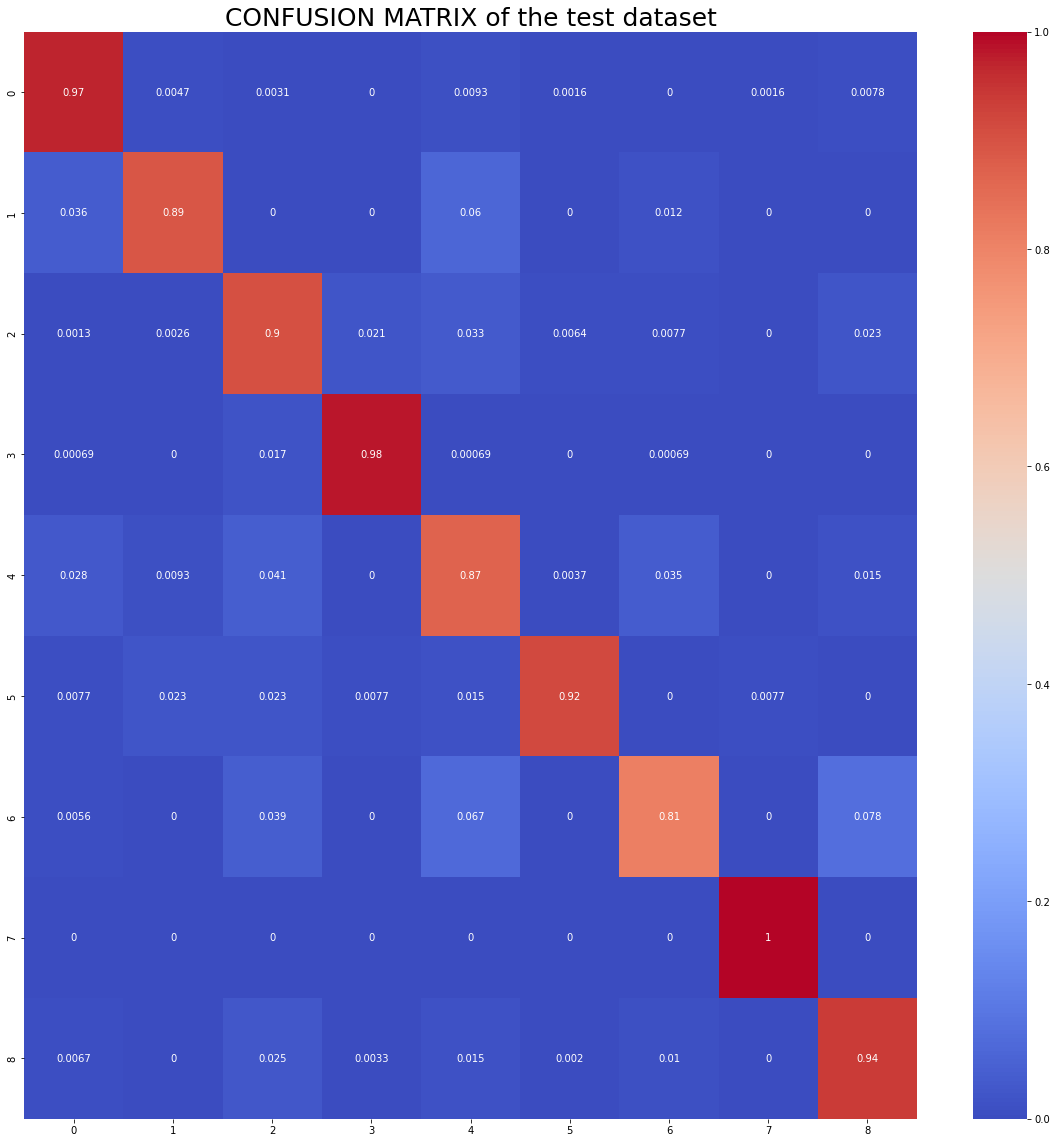

In [18]:
test(model, test_loader)

# Shap

In [33]:
import shap
model = resnet34(pretrained=False)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)

# LOAD trained model 
model.load_state_dict(torch.load(save_path))
model.eval()


sample = next(iter(test_loader))['img']
sample = sample[np.random.choice(sample.shape[0], 10, replace=False)].float()

AttributeError: 'Tensor' object has no attribute 'copy'

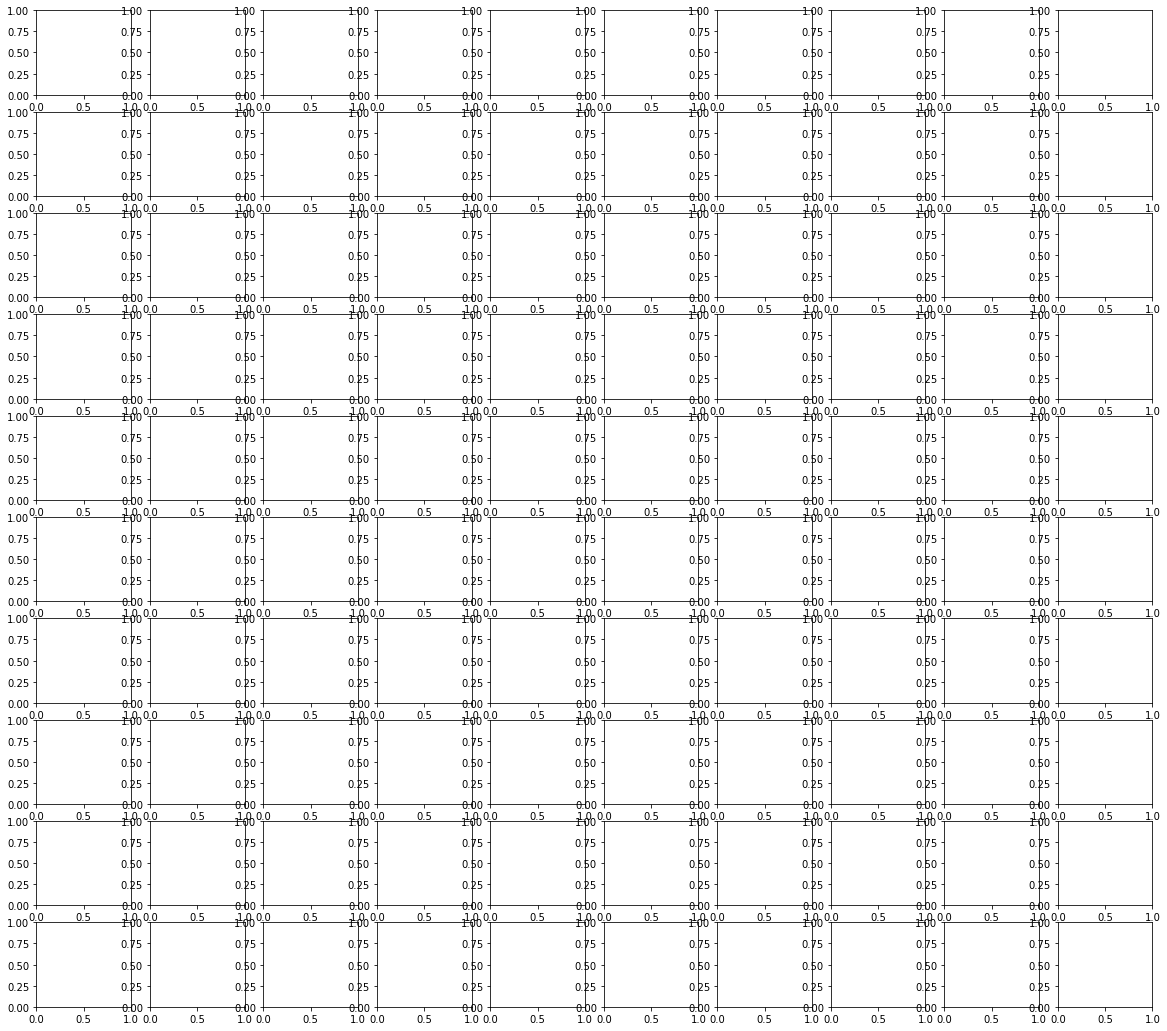

In [34]:
explainer = shap.GradientExplainer(model, sample)
shap_values = explainer.shap_values(sample)
shap.image_plot(shap_values, sample)